# Sentiment based multi-index integrated scoring method to improve the accuracy of recommender system
reference: https://www.sciencedirect.com/science/article/pii/S0957417421005467#b0230
4.3. Multi-index integrated scoring method

1. **Measure User Consistency per Aspect**

    * For each user $u$ and aspect $a$, compute the Pearson correlation

      $$
      C_{u,a} = \mathrm{Pearson}(\{r_{u,i,a}\},\{s_{u,i,a}\}).
      $$  demonstrates more reliably on that aspect, all without any de-noising step.


2. **Derive an Adaptive Weight**

   * Define

     $$
       w_{u,i,a} = 1 - C'_{u,a}.
     $$
   * Interpretation:

     * **High consistency** ($C'\approx1$) → $w\approx0$ → default to the explicit rating.
     * **Low consistency** → $w$ larger → rely more on sentiment.


3. **Fuse Rating & Sentiment per Aspect**

   * Compute the final, blended score:

     $$
       r^*_{u,i,a}
       = w_{u,i,a}\,s_{u,i,a}
       + (1 - w_{u,i,a})\,r_{u,i,a}.
     $$
   * Each aspect gets its own adaptive mix of numeric rating and text-derived sentiment.

4. **Integrate into Recommendation**

   * Treat the fused vector $\{r^*_{u,i,1},\dots,r^*_{u,i,A}\}$ as the user’s multi-aspect preference.
   * Plug this vector into your downstream model (e.g. multi-task matrix factorization or neural recommender).


# Reading data

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

In [13]:
df_train = pd.read_csv('../Data/RecSys_AspectSentiment_train.csv')
df_train.head()

,username,beer_id,feel_predicted_rating,look_predicted_rating,smell_predicted_rating,taste_predicted_rating,feel_true_rating,look_true_rating,smell_true_rating,taste_true_rating,date,text,overall,score
0,Mitchster,2614,3.960,3.940,3.940,3.940,2.500,3.500,3.500,3.500,2005-02-18,recommended nick liquormax loveland. bottle co...,3.00,3.30
1,avalon07,13874,4.270,4.255,4.260,4.255,3.750,4.125,3.625,3.625,2018-04-14,l: poured bottle pint glass. amber color cloud...,3.75,3.81
2,Kulrak,3999,2.420,2.410,2.420,2.420,2.000,3.000,1.500,1.500,2007-05-28,pours somewhat dark golden color crumbly white...,2.00,1.74
3,jampics2,95343,3.475,3.425,3.425,3.450,3.125,3.750,3.125,2.750,2013-07-01,"happy 25th great lakes! so, going hoppy lager ...",2.50,2.48
4,lacqueredmouse,28314,1.870,1.870,1.890,1.900,1.000,2.000,2.000,1.000,2006-11-04,"clear light yellow body, coarse-bubbled scummy...",1.50,1.40


In [15]:
df_test = pd.read_csv('../Data/RecSys_AspectSentiment_test.csv')
df_test.head()

,username,beer_id,feel_predicted_rating,look_predicted_rating,smell_predicted_rating,taste_predicted_rating,feel_true_rating,look_true_rating,smell_true_rating,taste_true_rating,date,text,overall,score
0,nokes,33201,3.940000,3.910000,3.940000,3.960000,4.000000,3.500000,3.500000,4.000000,2009-09-07,"went saskatchewan roughriders hefe glass, fill...",4.00,3.85
1,albern,30918,2.590000,2.560000,2.630000,2.620000,2.000000,3.000000,2.500000,1.000000,2008-07-13,"whoa, pretty bad beer. pours pale yellow tons ...",1.50,1.68
2,Amish_Ambush,88427,2.880000,2.860000,2.850000,2.860000,3.250000,3.000000,3.250000,2.500000,2013-01-21,sam adams spring variety pack? maple pecan por...,2.75,2.84
3,eberkman,65,2.385818,2.378909,2.388000,2.390909,2.195455,2.409091,1.963636,2.040909,2007-07-31,one buddy left one fridge came bunch stuff wan...,2.50,2.30
4,TechMyst,1708,4.037059,4.023529,4.027941,4.032353,4.500000,4.507353,4.426471,4.522059,2006-10-04,container volume: 750ml container type: bottle...,3.50,3.46


In [17]:
import numpy as np
from scipy.stats import pearsonr

aspects = ['feel', 'look', 'smell', 'taste']

def cprime_from_arrays(tr, pr):
    if tr.std() == 0 or pr.std() == 0:
        dist = np.linalg.norm(tr - pr)
        return 1.0 / (1.0 + dist)
    corr = pearsonr(tr, pr)[0]
    return (corr + 1.0) / 2.0

for asp in aspects:
    tcol = f'{asp}_true_rating'
    pcol = f'{asp}_predicted_rating'
    ccol = f'{asp}_C_prime'
    wcol = f'{asp}_w'
    rcol = f'{asp}_r_star'

    # Compute C' per user from training set
    c_per_user = df_train.groupby('username').apply(
        lambda g: cprime_from_arrays(g[tcol].values, g[pcol].values)
    )

    # Broadcast C' to train and test
    global_mean = c_per_user.mean()
    df_train[ccol] = df_train['username'].map(c_per_user)
    df_test[ccol] = df_test['username'].map(c_per_user).fillna(global_mean)

    # Compute weights
    df_train[wcol] = 1.0 - df_train[ccol]
    df_test[wcol] = 1.0 - df_test[ccol]

    # Fuse ratings
    df_train[rcol] = df_train[wcol] * df_train[pcol] + (1.0 - df_train[wcol]) * df_train[tcol]
    df_test[rcol] = df_test[wcol] * df_test[pcol] + (1.0 - df_test[wcol]) * df_test[tcol]

# Keep only username, beer_id, and r_star columns
keep = ['username', 'beer_id'] + [f'{asp}_r_star' for asp in aspects]
df_train = df_train[keep]
df_test = df_test[keep]


/var/folders/kc/rlj0hww930xfsv0_ns1r6c3w0000gn/T/ipykernel_43350/964562132.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  c_per_user = df_train.groupby('username').apply(
/var/folders/kc/rlj0hww930xfsv0_ns1r6c3w0000gn/T/ipykernel_43350/964562132.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  c_per_user = df_train.groupby('username').apply(
/var/folders/kc/rlj0hww930xfsv0_ns1r6c3w0000gn/T/ipykern

In [21]:
df_train

,username,beer_id,feel_r_star,look_r_star,smell_r_star,taste_r_star
0,Mitchster,2614,2.820137,3.587638,3.548359,3.571321
1,avalon07,13874,3.872023,4.134488,3.705450,3.750585
2,Kulrak,3999,2.000000,3.000000,1.500000,1.500000
3,jampics2,95343,3.169182,3.696930,3.176384,2.873151
4,lacqueredmouse,28314,1.103457,1.980947,1.987130,1.097399
...,...,...,...,...,...,...
15518,callmemickey,57269,3.119777,3.494384,3.472037,2.501220
15519,cvstrickland,6549,3.831853,4.466076,3.975974,3.666978
15520,MJR,1520,3.018367,3.248957,3.485454,3.466515
15521,BeerBelcher,34688,2.768127,2.990571,2.637901,2.434037


In [19]:
df_test

,username,beer_id,feel_r_star,look_r_star,smell_r_star,taste_r_star
0,nokes,33201,3.986460,3.592514,3.597048,3.990434
1,albern,30918,2.150349,2.981730,2.515177,1.258316
2,Amish_Ambush,88427,3.166506,2.968410,3.161774,2.586090
3,eberkman,65,2.236367,2.401736,1.969650,2.118668
4,TechMyst,1708,4.429263,4.392458,4.334418,4.384478
...,...,...,...,...,...,...
3876,Brolo75,7971,4.694140,4.580919,4.685124,4.747996
3877,HopsYeast,63860,3.831237,3.922667,3.580591,3.832503
3878,Jadjunk,1381,2.898615,3.408347,2.741817,2.626071
3879,Nuke77,17112,4.199381,4.201983,4.495073,4.294432


# user-based-collaborative-filtering

In [23]:
aspects = ['feel', 'look', 'smell', 'taste']
df_train['overall_r_star'] = df_train[[f'{asp}_r_star' for asp in aspects]].mean(axis=1)
df_test['overall_r_star'] = df_test[[f'{asp}_r_star' for asp in aspects]].mean(axis=1)
df_train

,username,beer_id,feel_r_star,look_r_star,smell_r_star,taste_r_star,overall_r_star
0,Mitchster,2614,2.820137,3.587638,3.548359,3.571321,3.381864
1,avalon07,13874,3.872023,4.134488,3.705450,3.750585,3.865636
2,Kulrak,3999,2.000000,3.000000,1.500000,1.500000,2.000000
3,jampics2,95343,3.169182,3.696930,3.176384,2.873151,3.228912
4,lacqueredmouse,28314,1.103457,1.980947,1.987130,1.097399,1.542233
...,...,...,...,...,...,...,...
15518,callmemickey,57269,3.119777,3.494384,3.472037,2.501220,3.146855
15519,cvstrickland,6549,3.831853,4.466076,3.975974,3.666978,3.985220
15520,MJR,1520,3.018367,3.248957,3.485454,3.466515,3.304823
15521,BeerBelcher,34688,2.768127,2.990571,2.637901,2.434037,2.707659


In [29]:
from surprise import Dataset, Reader, KNNBaseline
from surprise.model_selection import GridSearchCV

# Reader + load Dataset
reader = Reader(rating_scale=(df_train['overall_r_star'].min(),
                              df_train['overall_r_star'].max()))
data = Dataset.load_from_df(
    df_train[['username', 'beer_id', 'overall_r_star']],
    reader
)

# GridSearchCV for tuning
param_grid = {
    'k': [5, 10, 20, 40],
    'min_k': [1, 2, 5],
    'sim_options': {
        'name': ['pearson', 'cosine'],
        'user_based': [True]
    }
}
gs = GridSearchCV(
    KNNBaseline,
    param_grid,
    measures=['rmse'],
    cv=3,
    n_jobs=1
)
gs.fit(data)

print("Best RMSE score:", gs.best_score['rmse'])
print("Best parameters:", gs.best_params['rmse'])

# Build final trainset and model
trainset = data.build_full_trainset()
best_opts = gs.best_params['rmse']
algo = KNNBaseline(
    k=best_opts['k'],
    min_k=best_opts['min_k'],
    sim_options=best_opts['sim_options']
)

# Train model
algo.fit(trainset)

# Prepare test set
testset = list(
    df_test[['username', 'beer_id', 'overall_r_star']]
    .itertuples(index=False, name=None)
)

# Evaluate on test set
predictions = algo.test(testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


## Evaluation

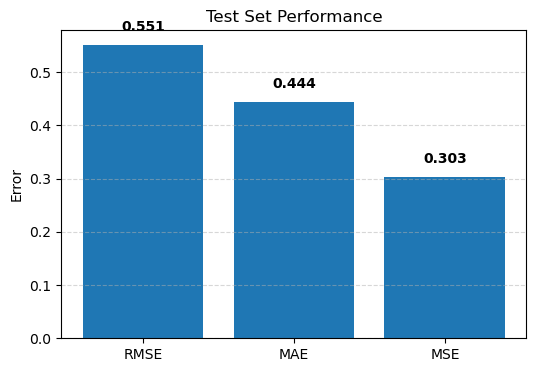

In [31]:
from surprise.accuracy import mse, rmse, mae
import matplotlib.pyplot as plt

rmse_score = rmse(predictions, verbose=False)
mae_score  = mae(predictions, verbose=False)
mse_score  = mse(predictions, verbose=False)

metrics = ['RMSE', 'MAE', 'MSE']
scores  = [rmse_score, mae_score, mse_score]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(metrics, scores)

for i, v in enumerate(scores):
    ax.text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontweight='bold')

ax.set_ylabel("Error")
ax.set_title("Test Set Performance")
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [33]:
# Example
def recommend_user(algo, trainset, user_id, N=5):
    """
    Returns a list of (item_id, estimated_score) for the top-N
    items the user has not yet rated.
    """
    try:
        inner_uid = trainset.to_inner_uid(user_id)
    except ValueError:
        return []  # user not in trainset

    # items the user has already rated
    seen_iids = {iid for (iid, _) in trainset.ur[inner_uid]}
    # map all internal iids back to raw ids
    raw_iids = [trainset.to_raw_iid(i) for i in trainset.all_items()]

    # candidates = those the user hasn't seen
    candidates = [iid for iid in raw_iids if trainset.to_inner_iid(iid) not in seen_iids]

    # predict each candidate
    scores = [(iid, algo.predict(user_id, iid).est) for iid in candidates]
    # sort by score descending and take top N
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores[:N]

for user in ['Boilermaker88', 'budgood1', 'draheim']:
    top5 = recommend_user(algo, trainset, user, N=5)
    print(f"\nTop-5 recommendations for {user}:")
    for beer_id, score in top5:
        print(f"  Beer {beer_id}: {score:.3f}")


Top-5 recommendations for Boilermaker88:
  Beer 7576: 4.988
  Beer 20194: 4.763
  Beer 170902: 4.678
  Beer 67833: 4.659
  Beer 14119: 4.652

Top-5 recommendations for budgood1:
  Beer 7576: 4.988
  Beer 857: 4.690
  Beer 3149: 4.681
  Beer 31956: 4.642
  Beer 23030: 4.636

Top-5 recommendations for draheim:
  Beer 149554: 4.289
  Beer 7971: 4.260
  Beer 1545: 4.236
  Beer 11757: 4.200
  Beer 19960: 4.194


# Comparison Summary: User-Based KNNBaseline With vs Without Sentiment Score

The user-based KNNBaseline model with sentiment score (`overall_r_star`) shows a clear improvement over the version without sentiment:

- **RMSE** decreased from **0.740** to **0.551**
- **MAE** decreased from **0.590** to **0.444**
- **MSE** decreased from **0.550** to **0.303**

These results indicate that incorporating aspect-level sentiment information significantly improves the model's ability to predict user preferences more accurately.